In [ ]:
import pandas as pd
import csv
import re
import time
import string
import numpy as np
from sklearn import preprocessing, model_selection, naive_bayes, svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import nltk
nltk.download('popular')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import pandas as pd
from matplotlib import pyplot as plt
#VADER es una biblioteca especificamente diseñada para el análisis de sentimientos en texto de redes sociales

from nltk.sentiment import SentimentIntensityAnalyzer


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=e09d4522e2aec274e9931a82613d551d007cf2f22b131b84f253e8d6f4bdf2f5
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
data = spark.read.csv('comentarios_ingles.csv', header=True, sep=",")
data.show(10)

+--------------------+
|     Cleaned_Comment|
+--------------------+
|           awwwww ;)|
|i just listened i...|
|   Ok, I'm crying...|
|We r lucky to wit...|
|50 years from now...|
|               Great|
|  this is a reupload|
|🥺❤❤❤♾ Straight t...|
|im listening the ...|
|We were all here ...|
+--------------------+
only showing top 10 rows



In [ ]:
data.printSchema()

root
 |-- Cleaned_Comment: string (nullable = true)



In [ ]:
df = data.toPandas()
print(df)

                                      Cleaned_Comment
0                                           awwwww ;)
1                        i just listened it’s amazing
2                                   Ok, I'm crying...
3                      We r lucky to witness this ❤️🙌
4   50 years from now we’ll be telling our grandki...
..                                                ...
81                                 """In 21th Century
82                 Love this song already. Thank you!
83  Tearing up hearing those harmonies. So so beau...
84                                             crying
85                              it was so beautiful 🥲

[86 rows x 1 columns]


In [ ]:
df.size # Esto imprimirá el número total de elementos en el DataFrame

86

In [ ]:
df.columns

Index(['Cleaned_Comment'], dtype='object')

In [ ]:
def analizar_sentimiento(texto):
    if texto is None or pd.isnull(texto):
        return np.nan

    sia = SentimentIntensityAnalyzer()
    sentimiento = sia.polarity_scores(str(texto))["compound"]

    if sentimiento > 0.1:
        return "Sentimiento Positivo"
    elif sentimiento < 0:
        return "Sentimiento Negativo"
    else:
        return "Sentimiento Neutral"


In [ ]:
sia= SentimentIntensityAnalyzer()

In [ ]:
df.columns

Index(['Cleaned_Comment'], dtype='object')

In [ ]:
df['Sentimiento'] = df['Cleaned_Comment'].apply(analizar_sentimiento)
df.head(10)

,Cleaned_Comment,Sentimiento
0,awwwww ;),Sentimiento Positivo
1,i just listened it’s amazing,Sentimiento Positivo
2,"Ok, I'm crying...",Sentimiento Positivo
3,We r lucky to witness this ❤️🙌,Sentimiento Positivo
4,50 years from now we’ll be telling our grandki...,Sentimiento Neutral
5,Great,Sentimiento Positivo
6,this is a reupload,Sentimiento Neutral
7,🥺❤❤❤♾ Straight to my heart.Proud to love this ...,Sentimiento Positivo
8,"im listening the beatles because of you, grand...",Sentimiento Negativo
9,We were all here when the Beatles released the...,Sentimiento Neutral


In [ ]:
def clean_text3(Comment):
  text = re.sub(r'^RT[\s]+', '', Comment)
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', Comment)
  text = re.sub(r'#', '', Comment)
  text = re.sub(r'@[A-Za-z0-9]+', '', Comment)
  return text

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Descargar el léxico de VADER
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Emoticones que indican Sentimiento Positivo
emoticones_positivos = ["❤️", "😍", "🔥", "🤍", "😊", "👏", "😭", "🙌", "🥰", "👀", "😢", "✨", "🎼", "👼", "♾️", "🥺", "💙", "🫶", "🏆", "🚬", "🤘", "💖", "💚", "🧡", "💜", "🎶", "🎸", "🥁", "🎤", "🦆"]


def analizar_sentimiento(comment_limpo):
    if comment_limpo is None or pd.isnull(comment_limpo):
        return np.nan

    sentimiento = sia.polarity_scores(comment_limpo)["compound"]

    # Analizar si el texto contiene emoticones positivos
    for emoticon in emoticones_positivos:
        if emoticon in comment_limpo:
            return "Positivo"

    if sentimiento > 0.1:
        return "Positivo"
    elif sentimiento < 0:
        return "Negativo"
    else:
        return "Neutral"


# Luego, puedes usar esta función para analizar el sentimiento en tus comentarios limpios
df['Sentimiento2'] = df['Cleaned_Comment'].apply(analizar_sentimiento)
df.head(10)  # Seleccionar las columnas que deseas imprimir


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Cleaned_Comment,Sentimiento,Sentimiento2
0,awwwww ;),Sentimiento Positivo,Positivo
1,i just listened it’s amazing,Sentimiento Positivo,Positivo
2,"Ok, I'm crying...",Sentimiento Positivo,Positivo
3,We r lucky to witness this ❤️🙌,Sentimiento Positivo,Positivo
4,50 years from now we’ll be telling our grandki...,Sentimiento Neutral,Positivo
5,Great,Sentimiento Positivo,Positivo
6,this is a reupload,Sentimiento Neutral,Neutral
7,🥺❤❤❤♾ Straight to my heart.Proud to love this ...,Sentimiento Positivo,Positivo
8,"im listening the beatles because of you, grand...",Sentimiento Negativo,Positivo
9,We were all here when the Beatles released the...,Sentimiento Neutral,Neutral


Counter({'Positivo': 61, 'Neutral': 18, 'Negativo': 7})


<Axes: xlabel='Sentimiento2', ylabel='count'>

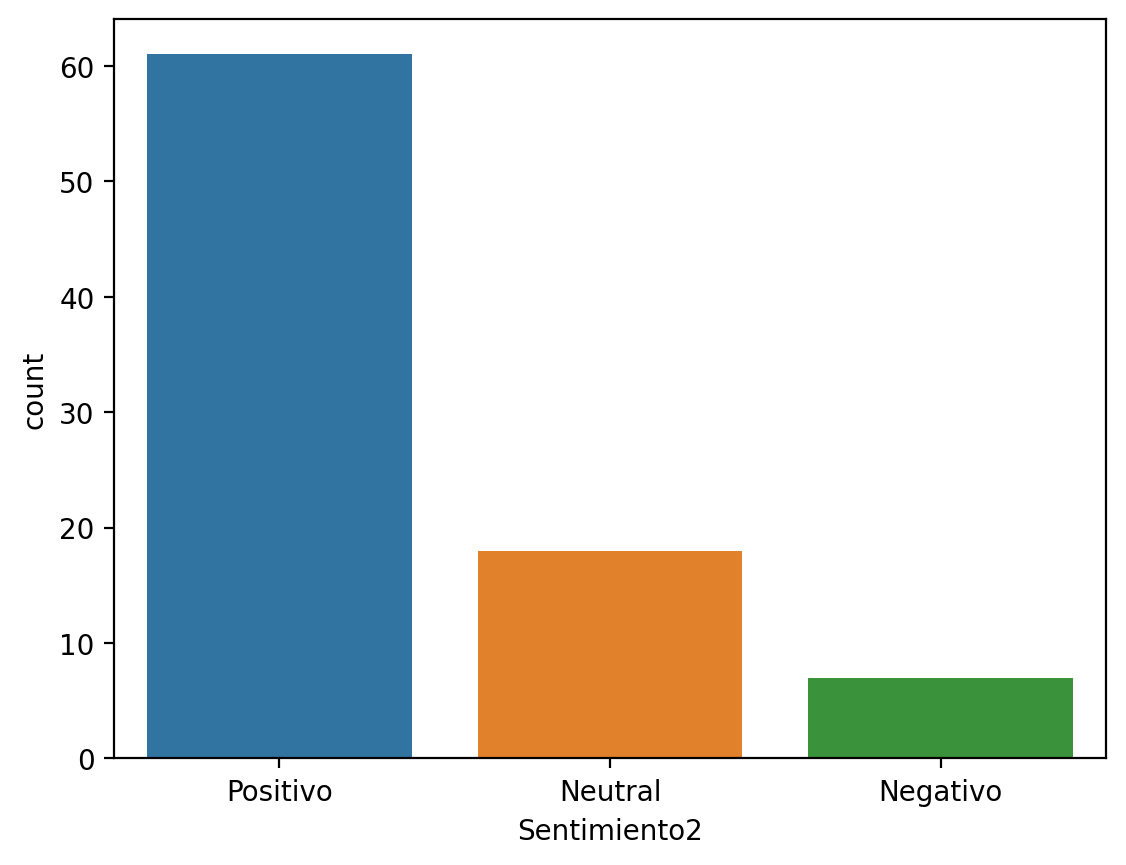

In [ ]:
x = df.Cleaned_Comment
y = df.Sentimiento2

from collections import Counter

print(Counter(y))
sns.countplot(x=y)

In [ ]:
df.head(10)

,Cleaned_Comment,Sentimiento,Sentimiento2
0,awwwww ;),Sentimiento Positivo,Positivo
1,i just listened it’s amazing,Sentimiento Positivo,Positivo
2,"Ok, I'm crying...",Sentimiento Positivo,Positivo
3,We r lucky to witness this ❤️🙌,Sentimiento Positivo,Positivo
4,50 years from now we’ll be telling our grandki...,Sentimiento Neutral,Positivo
5,Great,Sentimiento Positivo,Positivo
6,this is a reupload,Sentimiento Neutral,Neutral
7,🥺❤❤❤♾ Straight to my heart.Proud to love this ...,Sentimiento Positivo,Positivo
8,"im listening the beatles because of you, grand...",Sentimiento Negativo,Positivo
9,We were all here when the Beatles released the...,Sentimiento Neutral,Neutral


In [ ]:
df['SCORE'] = df.Sentimiento2

In [ ]:
# Reemplazar etiqueta para el conjunto de datos
df['SCORE'] = df['Sentimiento2'].map({'Positivo': 2, 'Negativo': 0, 'Neutral': 1})
df.head(10)


,Cleaned_Comment,Sentimiento,Sentimiento2,SCORE
0,awwwww ;),Sentimiento Positivo,Positivo,2
1,i just listened it’s amazing,Sentimiento Positivo,Positivo,2
2,"Ok, I'm crying...",Sentimiento Positivo,Positivo,2
3,We r lucky to witness this ❤️🙌,Sentimiento Positivo,Positivo,2
4,50 years from now we’ll be telling our grandki...,Sentimiento Neutral,Positivo,2
5,Great,Sentimiento Positivo,Positivo,2
6,this is a reupload,Sentimiento Neutral,Neutral,1
7,🥺❤❤❤♾ Straight to my heart.Proud to love this ...,Sentimiento Positivo,Positivo,2
8,"im listening the beatles because of you, grand...",Sentimiento Negativo,Positivo,2
9,We were all here when the Beatles released the...,Sentimiento Neutral,Neutral,1


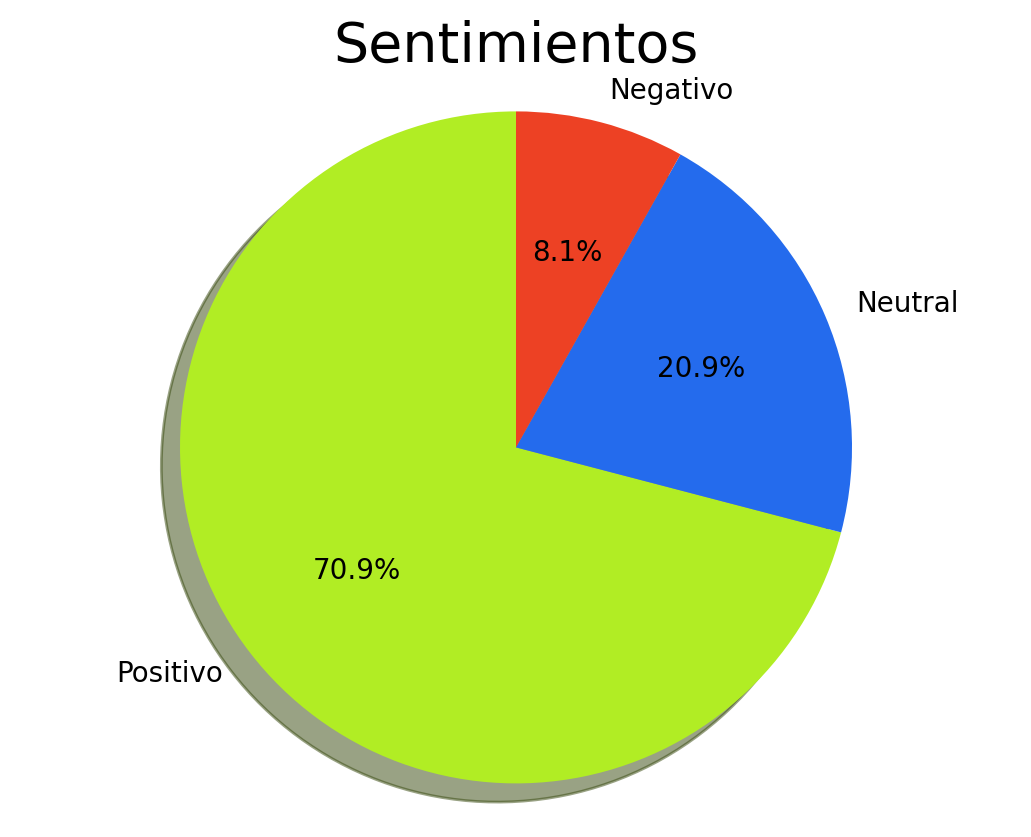

In [ ]:
import matplotlib.pyplot as plt

labels = 'Positivo', 'Neutral', 'Negativo'
colors = ['#B1ED24', '#246BED', '#ED4124']

plt.pie(df['SCORE'].value_counts(), labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Sentimientos', fontsize=20)
plt.axis('equal')
plt.show()


In [ ]:
print(df.columns)

Index(['Cleaned_Comment', 'Sentimiento', 'Sentimiento2', 'SCORE'], dtype='object')


In [ ]:
dfNew = df[['Sentimiento2','SCORE']]
dfNew.head()

,Sentimiento2,SCORE
0,Positivo,2
1,Positivo,2
2,Positivo,2
3,Positivo,2
4,Positivo,2


In [ ]:
df

,Cleaned_Comment,Sentimiento,Sentimiento2,SCORE
0,awwwww ;),Sentimiento Positivo,Positivo,2
1,i just listened it’s amazing,Sentimiento Positivo,Positivo,2
2,"Ok, I'm crying...",Sentimiento Positivo,Positivo,2
3,We r lucky to witness this ❤️🙌,Sentimiento Positivo,Positivo,2
4,50 years from now we’ll be telling our grandki...,Sentimiento Neutral,Positivo,2
...,...,...,...,...
81,"""""""In 21th Century",Sentimiento Neutral,Neutral,1
82,Love this song already. Thank you!,Sentimiento Positivo,Positivo,2
83,Tearing up hearing those harmonies. So so beau...,Sentimiento Positivo,Positivo,2
84,crying,Sentimiento Negativo,Negativo,0


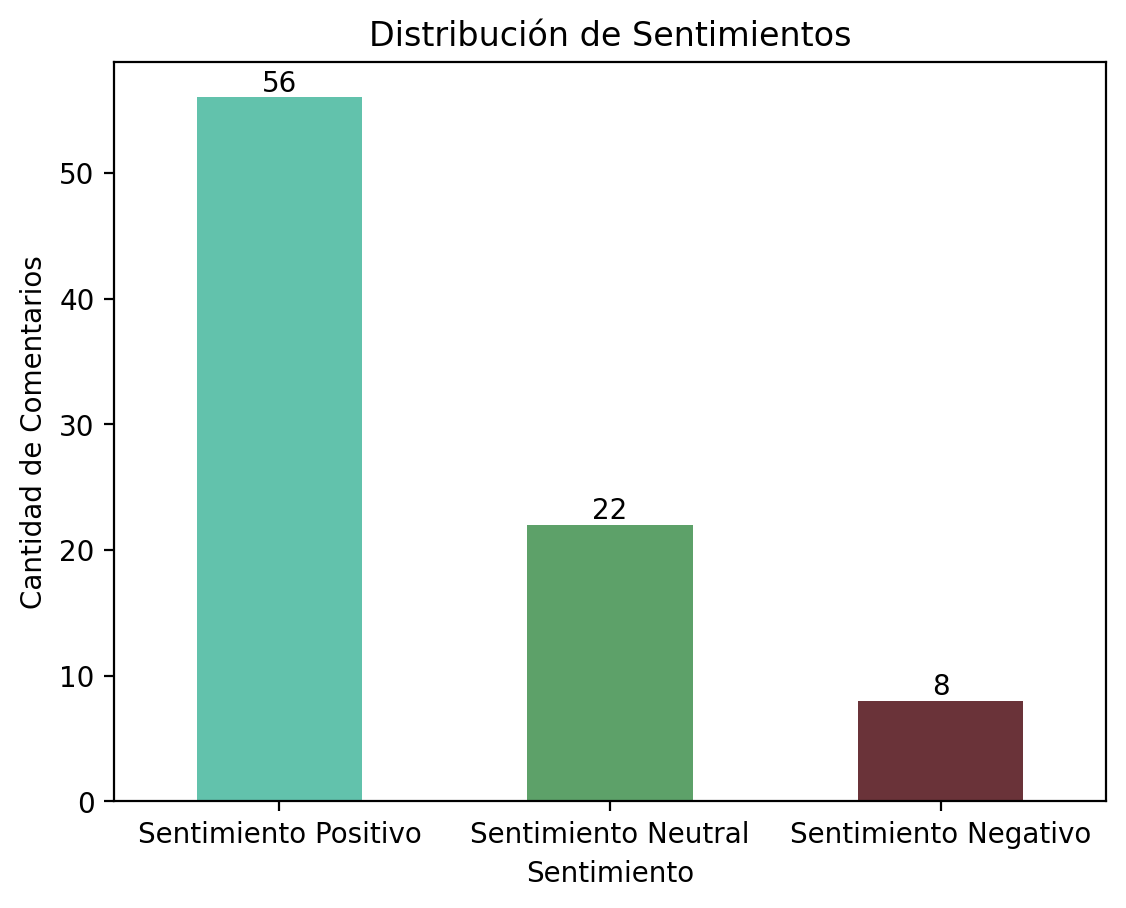

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Asignar valores a la columna 'compound' basándose en la columna 'SCORE'
df['compound'] = df['SCORE'].map({1.0: 'Positivo', 2.0: 'Neutro', 0.0: 'Negativo'})

#df['compound'] = df['SCORE'].map({1.0: 0.1, 2.0: 0, 0.0: -0.1})

# Gráfico de Barras para el Sentimiento con colores y etiquetas
sentimiento_counts = df['Sentimiento'].value_counts()
colors = ['#62C2AC', '#5DA169', '#6A3339']  # Colores para cada categoría de sentimiento
sentimiento_counts.plot(kind='bar', color=colors)
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Comentarios')

# Agregar etiquetas en las barras
for i, count in enumerate(sentimiento_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Rotar las etiquetas del eje x
plt.xticks(rotation=0)
plt.show()


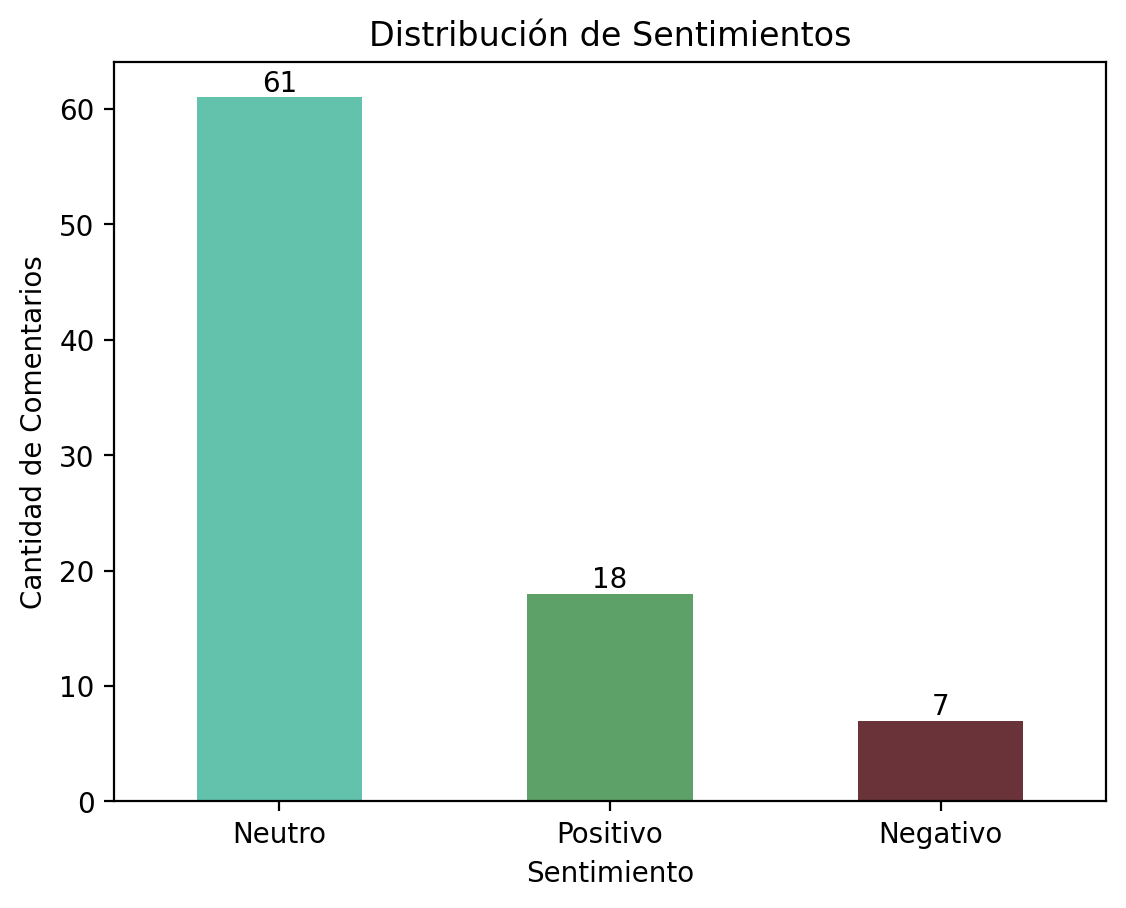

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Asignar valores a la columna 'compound' basándose en la columna 'SCORE'
df['compound'] = df['SCORE'].map({1.0: 'Positivo', 2.0: 'Neutro', 0.0: 'Negativo'})

# Gráfico de Barras para el Sentimiento con colores y etiquetas
sentimiento_counts = df['compound'].value_counts()
colors = ['#62C2AC', '#5DA169', '#6A3339']  # Colores para cada categoría de sentimiento
sentimiento_counts.plot(kind='bar', color=colors)
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Comentarios')

# Agregar etiquetas en las barras
for i, count in enumerate(sentimiento_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xticks(rotation=0)  # Rotar las etiquetas del eje x
plt.show()


In [ ]:
# Asignación aleatoria de datos de entrenamiento y prueba
import numpy as np
index = df.index
df['random_number'] = np.random.randn(len(index))
train = df[df['random_number'] <= 0.8]
test = df[df['random_number'] > 0.8]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Eliminar filas con valores nulos en la columna 'Comment'
train_clean = train.dropna(subset=['Cleaned_Comment'])

# Crear un nuevo vectorizador
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')

# Ajustar y transformar los datos de entrenamiento
train_matrix = vectorizer.fit_transform(train_clean['Cleaned_Comment'])

# Transformar los datos de prueba (ten en cuenta que no estamos ajustando nuevamente)
test_matrix = vectorizer.transform(test['Cleaned_Comment'])



In [ ]:
# REGRESION LINEAL
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [ ]:
X_train = train_matrix
X_test = test_matrix
y_train = train['SCORE']
y_test = test['SCORE']

In [ ]:
lr.fit(X_train,y_train)

LogisticRegression()

In [ ]:
predictions = lr.predict(X_test)

In [ ]:
from sklearn.metrics import roc_auc_score

def mide_error(nombre_modelo, y_pred):
    auc = roc_auc_score(y_test, y_pred)
    print(f'AUC de {nombre_modelo}: ', round(auc,2))

In [ ]:
from sklearn.metrics import roc_auc_score

def mide_error(nombre_modelo, y_pred):
    if len(np.unique(y_test)) > 2:
        # Si es un problema de clasificación múltiple, utilizamos 'ovr' en roc_auc_score
        auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    else:
        # Si es un problema de clasificación binaria, tomamos las probabilidades de la clase positiva
        auc = roc_auc_score(y_test, y_pred[:, 1])

    print(f'AUC de {nombre_modelo}: ', round(auc, 2))



# CALCULO DE ERROR REGRESION LOGISTICA
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='newton-cg', C=1.0)  # Puedes ajustar el valor de C
logreg.fit(X_train, y_train)

# Usamos predict_proba para obtener probabilidades
y_pred_proba = logreg.predict_proba(X_test)

# Medimos el error
mide_error('Regresión Logística', y_pred_proba)


AUC de Regresión Logística:  0.43


In [ ]:
# CALCULO DE ERROR NAIVE BAYES
from sklearn.naive_bayes import BernoulliNB

naive_bayes = BernoulliNB()
naive_bayes.fit(X_train, y_train)

# Usamos predict_proba para obtener probabilidades
y_pred_proba_nb = naive_bayes.predict_proba(X_test)

# Medimos el error
mide_error('Naive Bayes', y_pred_proba_nb)


AUC de Naive Bayes:  0.7


In [ ]:
# CALCULO DE ERROR ARBOL DE DECISION
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# Usamos predict_proba para obtener probabilidades
y_pred_proba_tree = tree.predict_proba(X_test)

# Medimos el error
mide_error('Árbol de Decisión', y_pred_proba_tree)


AUC de Árbol de Decisión:  0.5


In [ ]:
# CALCULO DE ERROR RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

# Usamos predict_proba para obtener probabilidades
y_pred_proba_rf = random_forest.predict_proba(X_test)

# Medimos el error
mide_error('Random Forest', y_pred_proba_rf)


AUC de Random Forest:  0.76


In [ ]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix, classification_report

# 'predictions' es la variable que contiene las predicciones
# 'y_test' es la variable que contiene las etiquetas verdaderas

# Convierte 'y_test' a un arreglo NumPy si aún no lo está
y_true = np.asarray(y_test)

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(predictions, y_true)

# Muestra la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

# Calcula y muestra el informe de clasificación
class_report = classification_report(predictions, y_true)
print("\nInforme de Clasificación:")
print(class_report)


Matriz de Confusión:
[[ 0  0  0]
 [ 0  0  0]
 [ 1  3 12]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.75      0.86        16

    accuracy                           0.75        16
   macro avg       0.33      0.25      0.29        16
weighted avg       1.00      0.75      0.86        16



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.75      0.86        16

    accuracy                           0.75        16
   macro avg       0.33      0.25      0.29        16
weighted avg       1.00      0.75      0.86        16



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**DE AQUI PA ARRIBA TODO GOOD**